Abaixo importaremos todas as LIBs necessárias para executar as ações

In [2]:
from fastbook import *
from fastai.vision.all import *
from fastdownload import download_url
# https://course.fast.ai/Lessons/lesson1.html

Agora iremos pesquisar por uma imagem do DDG e guardar sua URL

In [3]:
urls = search_images_ddg('foto de cachorros', max_images=3)
len(urls),urls[1]

(3,
 'https://www.perrosamigos.com/Uploads/perrosamigos.com/ImagenesGrandes/fotos-de-cachorros-0-4.jpg')

Faremos então o download da imagem pesquisada no diretório atual com o nome bird.jpg

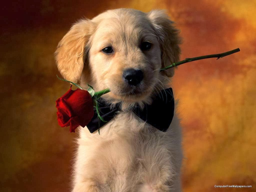

In [4]:
dest = 'cao.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Iremos baixar outra imagem no DDG para testar o modelo posteriormente

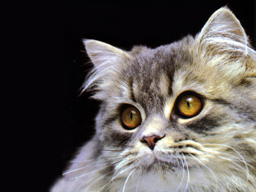

In [6]:
img_name = 'gato.jpg'
download_url(search_images_ddg('foto de gato', max_images=1)[0], img_name, show_progress=False)
Image.open(img_name).to_thumb(256,256)

Salvaremos em pastas com seus respectivos nomes utilizando searches e patch

In [7]:
searches = 'cachorro','gato'
path = Path('caes_gatos')

Baixaremos varias imagens para treinamento o modelo nos diretórios definidos

In [8]:

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo',max_images=10))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} sun photo',max_images=10))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} shade photo',max_images=10))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Abaixo será verificada as imagens baixadas caso tenha alguma imagem com problemas será excluída

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Enfim realizaremos o aprendizado e geração do modelo aprendido começaremos com o DataBlock carregando todas as imagens.

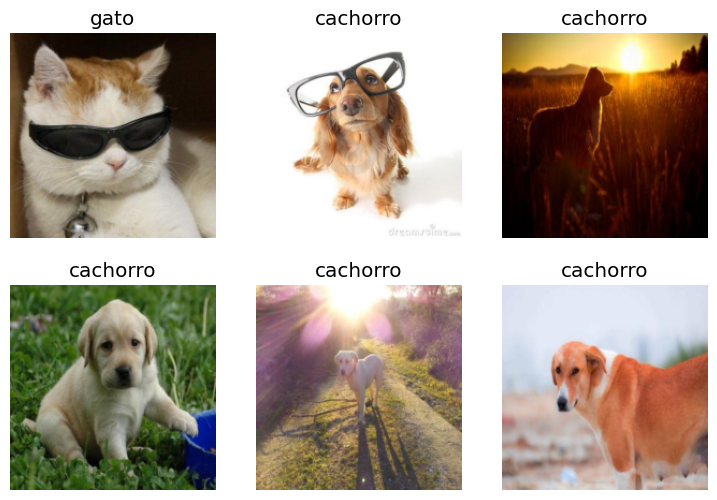

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Usaremos o modelo já difundido de reconhecimento de imagens resnet18, e realizaremos o refinamento do modelo.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

c:\Dominios\IA\noteTeste\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dominios\IA\noteTeste\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.933344,5.555660,0.454545,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.678824,4.613928,0.454545,00:09
1,0.595648,3.556207,0.454545,00:09
2,0.540724,2.833365,0.454545,00:09


Abaixo podemos testar o modelo já gerado

Isso é um: gato.
Probabilidade: 17.16%


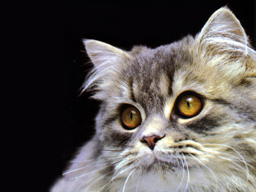

In [19]:
img_test = 'gato.jpg'
is_test,_,probs = learn.predict(PILImage.create(img_test))
print(f"Isso é um: {is_test}.")
proba = float(f"{probs[0]:.4f}")
print(f"Probabilidade: {proba * 100 }%")
im = Image.open(img_test)
im.to_thumb(256,256)

Finalmente iremos salvar nosso modelo aprendido para utilização posterior sem a necessidade de refazer o aprendizado.

In [17]:
learn.save('caes_gatos')
learn.export('caes_gatos.pkl')